## 修改训练集
## 修改网络结构，参考pilotnet
## 修改评估函数

In [1]:
import cv2
import numpy as np
import pandas as pd

In [2]:
mkv_file_path = ['./epochs/epoch{:02d}_front.mkv'.format(i) for i in range(1,10)]
steering_file_path = ['./epochs/epoch{:02d}_steering.csv'.format(i) for i in range(1,10)]
paths = [mkv_file_path,steering_file_path]

In [3]:
#数据预处理方法
def read_mkv(path):
    cap = cv2.VideoCapture(path)
    success,frame = cap.read()
    pic = []

    while(success):
        frame = cv2.resize(frame,(320,180),interpolation=cv2.INTER_CUBIC)
        pic.append(frame[80:-30,30:-30])

        success,frame = cap.read()
    return np.array(pic)

def read_steering(path):
    return pd.read_csv(path).wheel.values

In [4]:
# 读取所有视频和转向角度
features=[]
labels = []
for i in range(9):
    features.append(read_mkv(paths[0][i]))
    labels.append(read_steering(paths[1][i]))

In [5]:
features[0].shape

(1500, 70, 260, 3)

In [48]:
# 保存视频和转向角度
feature = np.concatenate(tuple(features))
label = np.concatenate(tuple(labels))
indices = np.random.permutation(feature.shape[0])
feature = feature[indices]
label = label[indices]
np.save('feature4.npy',feature)
print('feature saved successfully!')

np.save('label4.npy',label)
print('label saved successfully!')

feature saved successfully!
label saved successfully!


In [4]:
#加载数据
feature = np.load('feature4.npy')
print('feature3 loaded successfully!')
label = np.load('label4.npy')
print('label3 loaded successfully!')
feature.shape

feature3 loaded successfully!
label3 loaded successfully!


(24300, 70, 260, 3)

In [5]:
# feature = feature/255.

In [5]:
from keras.layers import Dense,Activation,Convolution2D,MaxPooling2D,Flatten,Dropout,BatchNormalization
from keras.models import Sequential
from keras.optimizers import Adam,Adadelta

Using TensorFlow backend.


In [18]:
model = Sequential()

model.add(BatchNormalization(input_shape=(70,260,3)))

model.add(Convolution2D(kernel_size=(5,5),filters = 24,padding='same',strides=(2,2),input_shape=(70,260,3),data_format='channels_last',kernel_initializer='truncated_normal'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(5,5),filters = 36,padding='same',strides=(2,2),data_format='channels_last'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(5,5),filters = 48,padding='same',strides=(2,2),data_format='channels_last'))
model.add(Activation('relu'))
model.add(BatchNormalization())

# model.add(Convolution2D(kernel_size=(5,5),filters = 128,padding='same',strides=(1,1),data_format='channels_last'))
# model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(kernel_size=(3,3),filters = 64,padding='same',strides=(1,1),data_format='channels_last'))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 64,padding='same',strides=(1,1),data_format='channels_last'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(kernel_size=(3,3),filters = 128,padding='same',strides=(1,1),data_format='channels_last'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 128,padding='same',strides=(1,1),data_format='channels_last'))
model.add(Activation('relu'))
model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(kernel_size=(3,3),filters = 256 ,padding='same',strides=(1,1),data_format='channels_last'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Convolution2D(kernel_size=(3,3),filters = 256,padding='same',strides=(1,1),data_format='channels_last'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1))
adam = Adadelta()

In [7]:
import keras.backend as K

def missing_rate(y_true, y_pred):
    return K.mean(abs(y_pred-y_true))/33.

In [19]:
model.compile(optimizer=adam,
             loss = 'mean_squared_error',
             metrics = [missing_rate])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_37 (Batc (None, 70, 260, 3)        12        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 35, 130, 24)       1824      
_________________________________________________________________
activation_34 (Activation)   (None, 35, 130, 24)       0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 35, 130, 24)       96        
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 18, 65, 36)        21636     
_________________________________________________________________
activation_35 (Activation)   (None, 18, 65, 36)        0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 18, 65, 36)        144       
__________

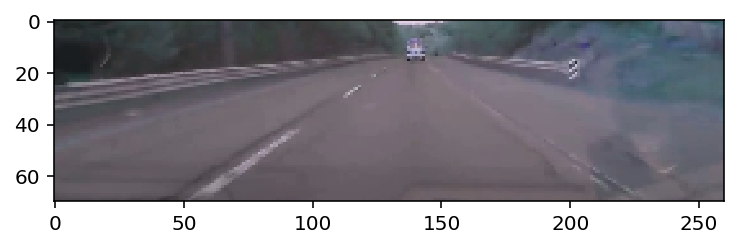

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.imshow(feature[10110])

In [28]:
model.fit(feature,label,batch_size=256,validation_split=0.1,epochs=5,shuffle=True)

Train on 21870 samples, validate on 2430 samples
Epoch 1/5
21870/21870 [==============================] - 29s - loss: 0.4315 - missing_rate: 0.0139 - val_loss: 0.1697 - val_missing_rate: 0.0087
Epoch 2/5
21870/21870 [==============================] - 29s - loss: 0.4189 - missing_rate: 0.0135 - val_loss: 0.2707 - val_missing_rate: 0.0116
Epoch 3/5
21870/21870 [==============================] - 29s - loss: 0.4280 - missing_rate: 0.0137 - val_loss: 0.2355 - val_missing_rate: 0.0098
Epoch 4/5
21870/21870 [==============================] - 29s - loss: 0.4651 - missing_rate: 0.0144 - val_loss: 0.3866 - val_missing_rate: 0.0144
Epoch 5/5
21870/21870 [==============================] - 29s - loss: 0.4055 - missing_rate: 0.0133 - val_loss: 0.1939 - val_missing_rate: 0.0096


In [27]:
model.fit(feature,label,batch_size=256,validation_split=0.1,epochs=5)

Train on 21870 samples, validate on 2430 samples
Epoch 1/5
21870/21870 [==============================] - 29s - loss: 0.4679 - missing_rate: 0.0140 - val_loss: 0.2227 - val_missing_rate: 0.0096
Epoch 2/5
21870/21870 [==============================] - 29s - loss: 0.4258 - missing_rate: 0.0136 - val_loss: 0.1522 - val_missing_rate: 0.0088
Epoch 3/5
21870/21870 [==============================] - 29s - loss: 0.4550 - missing_rate: 0.0140 - val_loss: 0.2311 - val_missing_rate: 0.0112
Epoch 4/5
21870/21870 [==============================] - 29s - loss: 0.4359 - missing_rate: 0.0139 - val_loss: 0.3058 - val_missing_rate: 0.0117
Epoch 5/5
21870/21870 [==============================] - 29s - loss: 0.4585 - missing_rate: 0.0139 - val_loss: 0.1649 - val_missing_rate: 0.0092


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 35, 160, 64)       9472      
_________________________________________________________________
activation_57 (Activation)   (None, 35, 160, 64)       0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 17, 79, 64)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 17, 79, 64)        36928     
_________________________________________________________________
activation_58 (Activation)   (None, 17, 79, 64)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 17, 79, 64)        36928     
_________________________________________________________________
activation_59 (Activation)   (None, 17, 79, 64)        0         
__________

In [29]:
#保存模型配置和权重
import h5py
model.save_weights('models/model_pilotPlus.h5')
with open('models/model_pilotPlus.json','w') as f:
    f.write(model.to_json())
    f.close()
    

In [2]:
from keras.models import model_from_json
with open('models/model3.json','r') as f:
    string = f.read()
model = model_from_json(string)
model.load_weights('models/model3.h5')

Using TensorFlow backend.


In [40]:
predict_feature = read_mkv('epochs/epoch10_front.mkv')
y_true = read_steering('epochs/epoch10_steering.csv')
model.evaluate(predict_feature,y_true,batch_size=128)

2688/2700 [============================>.] - ETA: 0s

[7.627263511375145, 0.070938456726294979]

In [18]:
predict_feature = read_mkv('epochs/epoch10_front.mkv')

In [37]:
model.predict(predict_feature)

array([[ 0.60254884],
       [ 0.78096074],
       [ 0.49349496],
       ..., 
       [-0.11413958],
       [ 0.24220835],
       [ 0.50120896]], dtype=float32)